In [15]:
from keras.datasets import boston_housing
from keras.datasets import reuters
import numpy as np
import os
from keras.models import Sequential
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import matplotlib.pyplot as plt
import time
import pandas as pd
import random
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from utils import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier 
import keras

In [2]:
#開檔
df = pd.read_excel(r'C:\Users\Big data\Desktop\class\funcardproject\斷詞與和卡額度_20群.xls',encoding='utf-16')
df = df.loc[:, ["age","serveTime","credLimit","Loan","SalPerY","holdCard","Career","credLimit_group"]] 
#若某raw有NAN則整RAW刪除
df =df.dropna(
    axis=0,     # 0: 对行进行操作; 1: 对列进行操作
    how='any'   # 'any': 只要存在 NaN 就 drop 掉; 'all': 必须全部是 NaN 才 drop 
    ) 
#把分群的Y轉成int
df['credLimit_group'] = df['credLimit_group'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1680 entries, 0 to 1686
Data columns (total 8 columns):
age                1680 non-null float64
serveTime          1680 non-null float64
credLimit          1680 non-null int64
Loan               1680 non-null float64
SalPerY            1680 non-null int64
holdCard           1680 non-null int64
Career             1680 non-null int64
credLimit_group    1680 non-null int32
dtypes: float64(3), int32(1), int64(4)
memory usage: 111.6 KB


In [8]:
#先打散資料(三次)
for i in range(3):
    df = shuffle(df)
#再切成訓練與測試
train_data, test_data, train_targets, test_targets = train_test_split(df.loc[:, ["age","serveTime","Loan","SalPerY","holdCard","Career"]] , df.loc[:, ["credLimit_group"]] , test_size=0.3, random_state=4)
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)
#轉array
train_data = np.array(train_data).astype(float)
test_data = np.array(test_data).astype(float)
train_targets = np.array(train_targets).astype(int)
test_targets = np.array(test_targets).astype(int)
#把Y弄成onehot
def to_one_hot(labels, dimension=20):
    results = np.zeros((len(labels),dimension))
    for i,label in enumerate(labels):
        results[i,label]=1.
    return results
train_targets = to_one_hot(train_targets)
test_targets = to_one_hot(test_targets)

(1176, 6)
(504, 6)
(1176, 1)
(504, 1)


In [9]:
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(1176, 6)
(504, 6)
(1176, 20)
(504, 20)


# 正規化(例如本資料serveTime與SalPerY不同單位且數值差異甚大,因此需轉為標準差)

In [10]:
# 標準化
# mean = train_data.mean(axis=0)
# train_data -=mean
# std = train_data.std(axis=0)
# train_data/=std
# test_data-=mean
# test_data/=std


In [11]:
#正規化
#因為relu,所以這個比較好
train_data_max = train_data.max(axis=0)
train_data_min = train_data.min(axis=0)
train_data_range = train_data_max-train_data_min
train_data-=train_data_min
train_data/=train_data_range

test_data_max = test_data.max(axis=0)
test_data_min = test_data.min(axis=0)
test_data_range = test_data_max-test_data_min
test_data-=test_data_min
test_data/=test_data_range

# RNN

In [12]:
X_train = np.array(train_data).reshape((train_data.shape[0], train_data.shape[1], 1))
X_test = np.array(test_data).reshape((test_data.shape[0], test_data.shape[1], 1))

In [24]:

def lstm():
    model = Sequential()
    model.add(LSTM(30, input_shape = (6,1), return_sequences = True))
    model.add(LSTM(30, return_sequences = True))
    model.add(LSTM(30, return_sequences = False))
    model.add(Dense(20))
    model.add(Activation('softmax'))
    
    Nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.01, schedule_decay=0.004)
    RMSprop = keras.optimizers.RMSprop(lr=0.001, rho=0.09, epsilon=0.001, decay=0.001)
    adam = optimizers.Adam(lr = 0.001)
    
    model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop, metrics = ['accuracy'])
    
    return model

In [25]:
model = KerasClassifier(build_fn = lstm, epochs = 700, batch_size = 200, verbose = 1)
history=model.fit(X_train, train_targets, validation_data=(X_test,test_targets))

Train on 1176 samples, validate on 504 samples
Epoch 1/700
1176/1176 [==============================] - 1s 789us/step - loss: 2.9887 - accuracy: 0.2032 - val_loss: 2.9783 - val_accuracy: 0.2619
Epoch 2/700
1176/1176 [==============================] - 0s 67us/step - loss: 2.9706 - accuracy: 0.2696 - val_loss: 2.9586 - val_accuracy: 0.2619
Epoch 3/700
1176/1176 [==============================] - 0s 69us/step - loss: 2.9495 - accuracy: 0.2696 - val_loss: 2.9351 - val_accuracy: 0.2619
Epoch 4/700
1176/1176 [==============================] - 0s 71us/step - loss: 2.9237 - accuracy: 0.2696 - val_loss: 2.9057 - val_accuracy: 0.2619
Epoch 5/700
1176/1176 [==============================] - 0s 68us/step - loss: 2.8914 - accuracy: 0.2696 - val_loss: 2.8678 - val_accuracy: 0.2619
Epoch 6/700
1176/1176 [==============================] - 0s 69us/step - loss: 2.8489 - accuracy: 0.2696 - val_loss: 2.8180 - val_accuracy: 0.2619
Epoch 7/700
1176/1176 [==============================] - 0s 70us/step - loss

1176/1176 [==============================] - 0s 68us/step - loss: 2.0009 - accuracy: 0.2696 - val_loss: 2.0043 - val_accuracy: 0.2619
Epoch 57/700
1176/1176 [==============================] - 0s 67us/step - loss: 2.0002 - accuracy: 0.2696 - val_loss: 2.0042 - val_accuracy: 0.2619
Epoch 58/700
1176/1176 [==============================] - 0s 74us/step - loss: 1.9998 - accuracy: 0.2696 - val_loss: 2.0038 - val_accuracy: 0.2619
Epoch 59/700
1176/1176 [==============================] - 0s 68us/step - loss: 2.0002 - accuracy: 0.2696 - val_loss: 2.0034 - val_accuracy: 0.2619
Epoch 60/700
1176/1176 [==============================] - 0s 67us/step - loss: 2.0006 - accuracy: 0.2696 - val_loss: 2.0037 - val_accuracy: 0.2619
Epoch 61/700
1176/1176 [==============================] - 0s 67us/step - loss: 1.9997 - accuracy: 0.2696 - val_loss: 2.0037 - val_accuracy: 0.2619
Epoch 62/700
1176/1176 [==============================] - 0s 68us/step - loss: 1.9999 - accuracy: 0.2696 - val_loss: 2.0044 - val_a

Epoch 112/700
1176/1176 [==============================] - 0s 67us/step - loss: 1.9982 - accuracy: 0.2696 - val_loss: 2.0050 - val_accuracy: 0.2619
Epoch 113/700
1176/1176 [==============================] - 0s 68us/step - loss: 1.9981 - accuracy: 0.2696 - val_loss: 2.0051 - val_accuracy: 0.2619
Epoch 114/700
1176/1176 [==============================] - 0s 79us/step - loss: 1.9977 - accuracy: 0.2696 - val_loss: 2.0050 - val_accuracy: 0.2619
Epoch 115/700
1176/1176 [==============================] - 0s 68us/step - loss: 1.9977 - accuracy: 0.2696 - val_loss: 2.0053 - val_accuracy: 0.2619
Epoch 116/700
1176/1176 [==============================] - 0s 68us/step - loss: 1.9981 - accuracy: 0.2696 - val_loss: 2.0052 - val_accuracy: 0.2619
Epoch 117/700
1176/1176 [==============================] - 0s 69us/step - loss: 1.9979 - accuracy: 0.2696 - val_loss: 2.0057 - val_accuracy: 0.2619
Epoch 118/700
1176/1176 [==============================] - 0s 73us/step - loss: 1.9980 - accuracy: 0.2696 - val_

1176/1176 [==============================] - 0s 67us/step - loss: 1.9900 - accuracy: 0.2696 - val_loss: 1.9980 - val_accuracy: 0.2619
Epoch 168/700
1176/1176 [==============================] - 0s 68us/step - loss: 1.9891 - accuracy: 0.2696 - val_loss: 1.9975 - val_accuracy: 0.2619
Epoch 169/700
1176/1176 [==============================] - 0s 67us/step - loss: 1.9890 - accuracy: 0.2696 - val_loss: 1.9965 - val_accuracy: 0.2619
Epoch 170/700
1176/1176 [==============================] - 0s 67us/step - loss: 1.9882 - accuracy: 0.2696 - val_loss: 1.9959 - val_accuracy: 0.2619
Epoch 171/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.9875 - accuracy: 0.2696 - val_loss: 1.9954 - val_accuracy: 0.2619
Epoch 172/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.9869 - accuracy: 0.2696 - val_loss: 1.9944 - val_accuracy: 0.2619
Epoch 173/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.9864 - accuracy: 0.2696 - val_loss: 1.9940 -

1176/1176 [==============================] - 0s 67us/step - loss: 1.8857 - accuracy: 0.2772 - val_loss: 1.8909 - val_accuracy: 0.2897
Epoch 223/700
1176/1176 [==============================] - 0s 75us/step - loss: 1.8846 - accuracy: 0.2789 - val_loss: 1.8896 - val_accuracy: 0.2917
Epoch 224/700
1176/1176 [==============================] - 0s 71us/step - loss: 1.8826 - accuracy: 0.2772 - val_loss: 1.8887 - val_accuracy: 0.2877
Epoch 225/700
1176/1176 [==============================] - 0s 69us/step - loss: 1.8809 - accuracy: 0.2772 - val_loss: 1.8870 - val_accuracy: 0.2857
Epoch 226/700
1176/1176 [==============================] - 0s 68us/step - loss: 1.8789 - accuracy: 0.2747 - val_loss: 1.8856 - val_accuracy: 0.2778
Epoch 227/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.8794 - accuracy: 0.2806 - val_loss: 1.8839 - val_accuracy: 0.2798
Epoch 228/700
1176/1176 [==============================] - 0s 68us/step - loss: 1.8771 - accuracy: 0.2798 - val_loss: 1.8856 -

1176/1176 [==============================] - 0s 67us/step - loss: 1.8449 - accuracy: 0.3138 - val_loss: 1.8560 - val_accuracy: 0.3115
Epoch 278/700
1176/1176 [==============================] - 0s 67us/step - loss: 1.8442 - accuracy: 0.3197 - val_loss: 1.8577 - val_accuracy: 0.3075
Epoch 279/700
1176/1176 [==============================] - 0s 68us/step - loss: 1.8436 - accuracy: 0.3197 - val_loss: 1.8555 - val_accuracy: 0.3036
Epoch 280/700
1176/1176 [==============================] - 0s 69us/step - loss: 1.8440 - accuracy: 0.3163 - val_loss: 1.8555 - val_accuracy: 0.3115
Epoch 281/700
1176/1176 [==============================] - 0s 70us/step - loss: 1.8453 - accuracy: 0.3129 - val_loss: 1.8549 - val_accuracy: 0.3016
Epoch 282/700
1176/1176 [==============================] - 0s 74us/step - loss: 1.8429 - accuracy: 0.3189 - val_loss: 1.8558 - val_accuracy: 0.3095
Epoch 283/700
1176/1176 [==============================] - 0s 70us/step - loss: 1.8433 - accuracy: 0.3214 - val_loss: 1.8544 -

1176/1176 [==============================] - 0s 78us/step - loss: 1.8242 - accuracy: 0.3240 - val_loss: 1.8408 - val_accuracy: 0.3095
Epoch 333/700
1176/1176 [==============================] - 0s 71us/step - loss: 1.8233 - accuracy: 0.3282 - val_loss: 1.8424 - val_accuracy: 0.3095
Epoch 334/700
1176/1176 [==============================] - 0s 70us/step - loss: 1.8255 - accuracy: 0.3223 - val_loss: 1.8374 - val_accuracy: 0.3036
Epoch 335/700
1176/1176 [==============================] - 0s 67us/step - loss: 1.8222 - accuracy: 0.3274 - val_loss: 1.8364 - val_accuracy: 0.3036
Epoch 336/700
1176/1176 [==============================] - 0s 68us/step - loss: 1.8225 - accuracy: 0.3316 - val_loss: 1.8363 - val_accuracy: 0.3075
Epoch 337/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.8227 - accuracy: 0.3291 - val_loss: 1.8376 - val_accuracy: 0.3155
Epoch 338/700
1176/1176 [==============================] - 0s 65us/step - loss: 1.8223 - accuracy: 0.3257 - val_loss: 1.8384 -

1176/1176 [==============================] - 0s 69us/step - loss: 1.8110 - accuracy: 0.3248 - val_loss: 1.8267 - val_accuracy: 0.3115
Epoch 388/700
1176/1176 [==============================] - 0s 70us/step - loss: 1.8118 - accuracy: 0.3282 - val_loss: 1.8267 - val_accuracy: 0.3095
Epoch 389/700
1176/1176 [==============================] - 0s 67us/step - loss: 1.8114 - accuracy: 0.3206 - val_loss: 1.8263 - val_accuracy: 0.3115
Epoch 390/700
1176/1176 [==============================] - 0s 65us/step - loss: 1.8112 - accuracy: 0.3240 - val_loss: 1.8256 - val_accuracy: 0.3115
Epoch 391/700
1176/1176 [==============================] - 0s 67us/step - loss: 1.8105 - accuracy: 0.3282 - val_loss: 1.8260 - val_accuracy: 0.3115
Epoch 392/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.8106 - accuracy: 0.3257 - val_loss: 1.8258 - val_accuracy: 0.3095
Epoch 393/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.8101 - accuracy: 0.3248 - val_loss: 1.8271 -

1176/1176 [==============================] - 0s 68us/step - loss: 1.8037 - accuracy: 0.3265 - val_loss: 1.8192 - val_accuracy: 0.3194
Epoch 443/700
1176/1176 [==============================] - 0s 68us/step - loss: 1.8036 - accuracy: 0.3282 - val_loss: 1.8220 - val_accuracy: 0.3155
Epoch 444/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.8042 - accuracy: 0.3231 - val_loss: 1.8202 - val_accuracy: 0.3155
Epoch 445/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.8038 - accuracy: 0.3248 - val_loss: 1.8226 - val_accuracy: 0.3135
Epoch 446/700
1176/1176 [==============================] - 0s 65us/step - loss: 1.8050 - accuracy: 0.3214 - val_loss: 1.8221 - val_accuracy: 0.3155
Epoch 447/700
1176/1176 [==============================] - 0s 67us/step - loss: 1.8037 - accuracy: 0.3248 - val_loss: 1.8192 - val_accuracy: 0.3194
Epoch 448/700
1176/1176 [==============================] - 0s 68us/step - loss: 1.8038 - accuracy: 0.3248 - val_loss: 1.8207 -

1176/1176 [==============================] - 0s 66us/step - loss: 1.7999 - accuracy: 0.3257 - val_loss: 1.8193 - val_accuracy: 0.3175
Epoch 498/700
1176/1176 [==============================] - 0s 82us/step - loss: 1.7998 - accuracy: 0.3248 - val_loss: 1.8173 - val_accuracy: 0.3194
Epoch 499/700
1176/1176 [==============================] - 0s 79us/step - loss: 1.7998 - accuracy: 0.3308 - val_loss: 1.8159 - val_accuracy: 0.3135
Epoch 500/700
1176/1176 [==============================] - 0s 91us/step - loss: 1.7995 - accuracy: 0.3299 - val_loss: 1.8158 - val_accuracy: 0.3095
Epoch 501/700
1176/1176 [==============================] - 0s 80us/step - loss: 1.7998 - accuracy: 0.3282 - val_loss: 1.8170 - val_accuracy: 0.3155
Epoch 502/700
1176/1176 [==============================] - 0s 76us/step - loss: 1.8003 - accuracy: 0.3274 - val_loss: 1.8158 - val_accuracy: 0.3095
Epoch 503/700
1176/1176 [==============================] - 0s 75us/step - loss: 1.7996 - accuracy: 0.3240 - val_loss: 1.8150 -

1176/1176 [==============================] - 0s 83us/step - loss: 1.7973 - accuracy: 0.3282 - val_loss: 1.8186 - val_accuracy: 0.3194
Epoch 553/700
1176/1176 [==============================] - 0s 83us/step - loss: 1.7969 - accuracy: 0.3248 - val_loss: 1.8134 - val_accuracy: 0.3194
Epoch 554/700
1176/1176 [==============================] - 0s 87us/step - loss: 1.7968 - accuracy: 0.3274 - val_loss: 1.8131 - val_accuracy: 0.3194
Epoch 555/700
1176/1176 [==============================] - 0s 76us/step - loss: 1.7968 - accuracy: 0.3274 - val_loss: 1.8167 - val_accuracy: 0.3234
Epoch 556/700
1176/1176 [==============================] - 0s 70us/step - loss: 1.7959 - accuracy: 0.3257 - val_loss: 1.8122 - val_accuracy: 0.3175
Epoch 557/700
1176/1176 [==============================] - 0s 73us/step - loss: 1.7972 - accuracy: 0.3274 - val_loss: 1.8130 - val_accuracy: 0.3194
Epoch 558/700
1176/1176 [==============================] - 0s 74us/step - loss: 1.7963 - accuracy: 0.3265 - val_loss: 1.8145 -

1176/1176 [==============================] - 0s 71us/step - loss: 1.7952 - accuracy: 0.3274 - val_loss: 1.8131 - val_accuracy: 0.3135
Epoch 608/700
1176/1176 [==============================] - 0s 70us/step - loss: 1.7955 - accuracy: 0.3240 - val_loss: 1.8129 - val_accuracy: 0.3175
Epoch 609/700
1176/1176 [==============================] - 0s 80us/step - loss: 1.7949 - accuracy: 0.3231 - val_loss: 1.8137 - val_accuracy: 0.3155
Epoch 610/700
1176/1176 [==============================] - 0s 77us/step - loss: 1.7942 - accuracy: 0.3231 - val_loss: 1.8129 - val_accuracy: 0.3155
Epoch 611/700
1176/1176 [==============================] - 0s 79us/step - loss: 1.7944 - accuracy: 0.3257 - val_loss: 1.8151 - val_accuracy: 0.3234
Epoch 612/700
1176/1176 [==============================] - 0s 73us/step - loss: 1.7946 - accuracy: 0.3248 - val_loss: 1.8121 - val_accuracy: 0.3234
Epoch 613/700
1176/1176 [==============================] - 0s 70us/step - loss: 1.7946 - accuracy: 0.3265 - val_loss: 1.8128 -

1176/1176 [==============================] - 0s 66us/step - loss: 1.7926 - accuracy: 0.3282 - val_loss: 1.8107 - val_accuracy: 0.3234
Epoch 663/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.7926 - accuracy: 0.3257 - val_loss: 1.8124 - val_accuracy: 0.3155
Epoch 664/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.7926 - accuracy: 0.3257 - val_loss: 1.8095 - val_accuracy: 0.3214
Epoch 665/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.7926 - accuracy: 0.3248 - val_loss: 1.8122 - val_accuracy: 0.3214
Epoch 666/700
1176/1176 [==============================] - 0s 66us/step - loss: 1.7922 - accuracy: 0.3274 - val_loss: 1.8114 - val_accuracy: 0.3214
Epoch 667/700
1176/1176 [==============================] - 0s 67us/step - loss: 1.7924 - accuracy: 0.3274 - val_loss: 1.8097 - val_accuracy: 0.3155
Epoch 668/700
1176/1176 [==============================] - 0s 67us/step - loss: 1.7925 - accuracy: 0.3265 - val_loss: 1.8093 -

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 35347 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32244 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 33287 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 39511 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 35657 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30340 missing from c

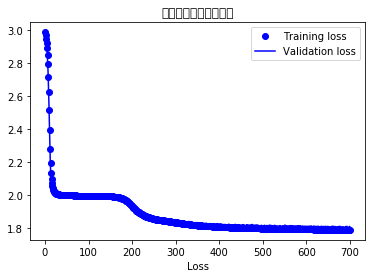

In [26]:
#繪圖

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+ 1)
plt.plot(epochs, loss,'bo',label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('訓練與驗證的損失函數')
plt.xlabel('Epohs')
plt.xlabel('Loss')
plt.legend()
plt.show()

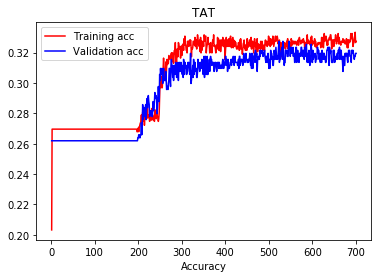

In [27]:
plt.clf()
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']

plt.plot(epochs, acc, 'r',label='Training acc')
plt.plot(epochs, val_acc,'b',label='Validation acc')
plt.title('TAT')
plt.xlabel('Epohs')
plt.xlabel('Accuracy')
plt.legend()
plt.show()

# 測試 小綠同學

In [320]:
小綠 = pd.DataFrame(columns=["age","serveTime","Loan","SalPerY","holdCard","Career"])
小綠.loc[0]=8,120,4,600000,1,1
小綠.loc[1]=28,12,0,600000,0,0
小綠.loc[2]=28,12,0,87,2,0
小綠

,age,serveTime,Loan,SalPerY,holdCard,Career
0,8,120,4,600000,1,1
1,28,12,0,600000,0,0
2,28,12,0,87,2,0


In [321]:
#轉array
小綠 = np.array(小綠).astype(float)

In [322]:
#先打散資料(三次)
for i in range(3):
    df = shuffle(df)
#再切成訓練與測試
train_data, test_data, train_targets, test_targets = train_test_split(df.loc[:, ["age","serveTime","Loan","SalPerY","holdCard","Career"]] , df.loc[:, ["credLimit_group"]] , test_size=0.3, random_state=42)
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)
#轉array
train_data = np.array(train_data).astype(float)
test_data = np.array(test_data).astype(float)
train_targets = np.array(train_targets).astype(int)
test_targets = np.array(test_targets).astype(int)
#把Y弄成onehot
def to_one_hot(labels, dimension=20):
    results = np.zeros((len(labels),dimension))
    for i,label in enumerate(labels):
        results[i,label]=1.
    return results
train_targets = to_one_hot(train_targets)
test_targets = to_one_hot(test_targets)
train_data_max = train_data.max(axis=0)
train_data_min = train_data.min(axis=0)
train_data_range = train_data_max-train_data_min
小綠-=train_data_min
小綠/=train_data_range
#多一維
小綠 = np.array(小綠).reshape((小綠.shape[0], 小綠.shape[1], 1))

(1176, 6)
(504, 6)
(1176, 1)
(504, 1)


In [323]:
# 他給出的是每一群的機率(相加為一)
preds = model.predict(小綠)
[print("一號小綠被分在第",preds[i],"群") for i in range(len(小綠))]

3/3 [==============================] - 0s 9ms/step
一號小綠被分在第 0 群
一號小綠被分在第 1 群
一號小綠被分在第 4 群


[None, None, None]